Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

import utils

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
boxsize = experiment.environments[0].boxsize

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_all_clusters.npz")
clusters = [module_indices[f] for f in module_indices.files]

torus_cells = list(clusters[2]) + list(clusters[12]) + list(clusters[15])
torus_cells.sort()
clustered_grid_cells = clusters[1]
border_cells = list(clusters[3]) + list(clusters[8])
border_cells.sort()
place_cells = clusters[10]
# include the rest of the cells in the unsorted cells (18 clusters total)
unsorted_cells = list(clusters[0]) + list(clusters[4]) + list(clusters[5]) + list(clusters[6]) + list(clusters[7]) + \
    list(clusters[9]) + list(clusters[11]) + list(clusters[13]) + list(clusters[14]) + list(clusters[16]) + list(clusters[17])
unsorted_cells.sort()
print(f"{len(torus_cells)=}, {len(clustered_grid_cells)=}, {len(border_cells)=}, {len(place_cells)=}, {len(unsorted_cells)=}")
clusters = [torus_cells, clustered_grid_cells, border_cells, place_cells, unsorted_cells]
cluster_labels = ["torus", "clustered grid", "border", "place", "unsorted"]

len(torus_cells)=604, len(clustered_grid_cells)=85, len(border_cells)=167, len(place_cells)=103, len(unsorted_cells)=2172


In [5]:
gc_scores = []
score_filenames = os.listdir(experiment.paths["grid_scores"])
for fname in score_filenames:
    if not "novel" in fname:
        with open(experiment.paths["grid_scores"] / f"{fname}", "rb") as f:
            gc_scores.append(pickle.load(f))
gc_scores = np.array(gc_scores)
# sort by sum (across environments) of scores
gcs_sorted = np.argsort(gc_scores.sum(axis=0))[::-1]

In [6]:
print(len(set(gcs_sorted[:100]).intersection(set(torus_cells))))
print(len(set(gcs_sorted[:100]).intersection(set(clustered_grid_cells))))
print(len(set(gcs_sorted[:100]).intersection(set(border_cells))))
print(len(set(gcs_sorted[:100]).intersection(set(place_cells))))
print(len(set(gcs_sorted[:100]).intersection(set(unsorted_cells))))

4
29
0
3
64


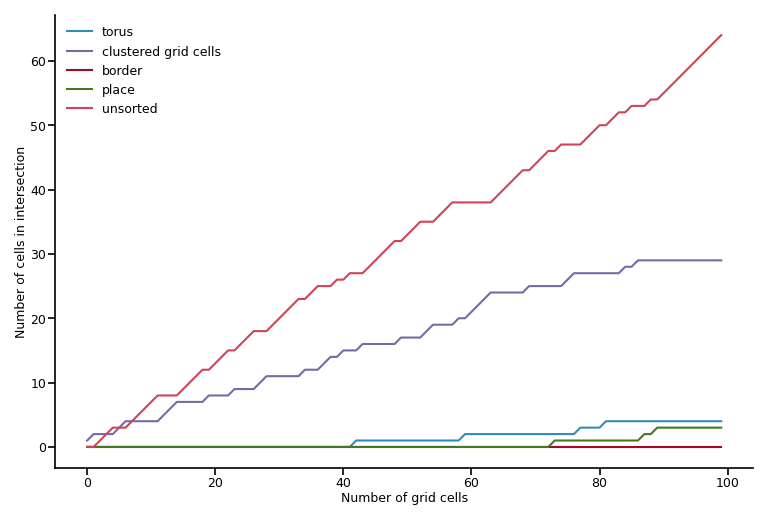

In [7]:
# cumulative intersection - how many of each cell type are included in the top 100 grid cells?
ci_torus = []
ci_cgcs = []
ci_border = []
ci_place = []
ci_unsorted = []
for i in range(1, 101):
    ci_torus.append(len(set(gcs_sorted[:i]).intersection(set(torus_cells))))
    ci_cgcs.append(len(set(gcs_sorted[:i]).intersection(set(clustered_grid_cells))))
    ci_border.append(len(set(gcs_sorted[:i]).intersection(set(border_cells))))
    ci_place.append(len(set(gcs_sorted[:i]).intersection(set(place_cells))))
    ci_unsorted.append(len(set(gcs_sorted[:i]).intersection(set(unsorted_cells))))

plt.figure()#figsize=(8, 6))
plt.plot(ci_torus, label="torus")
plt.plot(ci_cgcs, label="clustered grid cells")
plt.plot(ci_border, label="border")
plt.plot(ci_place, label="place")
plt.plot(ci_unsorted, label="unsorted")
plt.legend()
plt.xlabel("Number of grid cells")
plt.ylabel("Number of cells in intersection")
plt.show()

In [8]:
def load_model(experiment, random_model=False):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    if not random_model:
        model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)
random_model = load_model(experiment, random_model=True)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999
Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [9]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
seq_len = 40
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=seq_len)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [10]:
from tqdm import tqdm

def prune_model(model, random_model, dataloader, clusters, gcs_sorted, seq_len=40, step=1, ncells2prune=100, nsamples=30):
    errors = np.zeros((nsamples, int(seq_len/step), len(clusters)+4))
    i = 0
    for inputs, labels, positions, indices in tqdm(dataloader, total=min(len(dataloader), nsamples), desc="Processing batches"):
        if i == nsamples:
            break
        
        positions = positions.to(model.device, dtype=model.dtype)
        
        for k, cluster in enumerate(clusters):
            prune_idxs = np.random.choice(cluster, ncells2prune if len(cluster) > ncells2prune else len(cluster), replace=False)
            model.prune_mask = prune_idxs
            log_predictions = model(inputs, log_softmax=True) 

            for j in range(0, seq_len, step):
                trajectory_slice = slice(j, j+step)
                positions_slice = slice(j, j+step+1)
                errors[i,j,k] = model.position_error(log_predictions[:,trajectory_slice],
                                                     positions[:,positions_slice], indices, model.place_cell_ensembles).item()

        # Calculate log_predictions for other pruning scenarios
        random_log_predictions = random_model(inputs, log_softmax=True)
        model.prune_mask = gcs_sorted[:ncells2prune].copy()
        log_predictions_top_gc = model(inputs, log_softmax=True)
        model.prune_mask = []
        log_predictions_unpruned = model(inputs, log_softmax=True)
        prune_idxs = np.random.choice(np.arange(model.Ng), ncells2prune, replace=False).astype(int)
        model.prune_mask = prune_idxs
        log_predictions_random_pruning = model(inputs, log_softmax=True)

        for j in range(0, seq_len, step):
            trajectory_slice = slice(j, j+step)
            positions_slice = slice(j, j+step+1)
            
            # random model
            errors[i,j,len(clusters)] = random_model.position_error(random_log_predictions[:,trajectory_slice],
                                                                    positions[:,positions_slice], indices, random_model.place_cell_ensembles).item()
            # top 100 grid cells
            errors[i,j,len(clusters)+1] = model.position_error(log_predictions_top_gc[:,trajectory_slice],
                                                               positions[:,positions_slice], indices, model.place_cell_ensembles).item()
            # unpruned model
            errors[i,j,len(clusters)+2] = model.position_error(log_predictions_unpruned[:,trajectory_slice],
                                                               positions[:,positions_slice], indices, model.place_cell_ensembles).item()
            # random pruning from all cells
            errors[i,j,len(clusters)+3] = model.position_error(log_predictions_random_pruning[:,trajectory_slice],
                                                               positions[:,positions_slice], indices, model.place_cell_ensembles).item()

        i += 1
    return errors


In [11]:
nstats = 30
load_stats = True

if load_stats:
    with open(experiment.paths['experiment'] / "time_pruning.pkl", "rb") as f:
        pruning_errors = pickle.load(f)
else:
    pruning_errors = prune_model(model, random_model, dataloader, clusters, gcs_sorted, seq_len=seq_len, step=1, ncells2prune=100, nsamples=nstats)
    # save pruning errors statistics - since it takes so long to compute it can be loaded instead
    with open(experiment.paths['experiment'] / "time_pruning.pkl", "wb") as f:
        pickle.dump(pruning_errors, f)

In [12]:
panesize = set_size(width=345, mode='tall')
panesize

figsize=(panesize[0],panesize[1]*2/6)
figsize=np.array(figsize)

In [21]:
pruning_errors.shape

(30, 40, 9)

In [26]:
print(*zip(cluster_labels, range(len(clusters))))
#labels = ['Full Model', 'Random Pruning', 'High GCs Pruning', 'Exclusive GCs', 'Random Torus Pruning', 'Full Untrained Model']

('torus', 0) ('clustered grid', 1) ('border', 2) ('place', 3) ('unsorted', 4)


In [ ]:
fig, ax = plt.subplots(figsize=figsize)
x_ticks = np.arange(0,seq_len,1)
# redefine labels and line styles to change order of plotting
labels = cluster_labels + ['Full Untrained Model'] + ['Sorted High GCs Pruning'] + ['Full Model'] + ['Random Pruning']
labels[0] = 'Torus Pruning'
ls = ['-']*len(labels)
ls[1] = '-.'
ls[-2] = '-.'

mean_error = np.mean(pruning_errors,axis=0).T
std_error = np.std(pruning_errors,axis=0).T
median_error = np.median(pruning_errors,axis=0).T
mad_error = mad(pruning_errors,axis=0).T
for i in [0,6,5,7,8]: # set order to change color according to color-cycler
    #ax.plot(x_ticks, mean_error[i], label=labels[i])#np.mean(pruning_i,axis=0))
    #ax.fill_between(x_ticks, mean_error[i] + std_error[i], mean_error[i] - std_error[i], alpha=0.1)
    ax.plot(x_ticks, median_error[i], label=labels[i], ls=ls[i])#np.mean(pruning_i,axis=0))
    ax.fill_between(x_ticks, median_error[i] + mad_error[i], median_error[i] - mad_error[i], alpha=0.1)

ax.legend()
ax.set_xlabel('Time steps')
ax.set_ylabel('Decoding Error')
ax.axvline(20, c='k', ls='--')

fig.savefig(experiment.paths['experiment'] / f'plots/time_pruning')


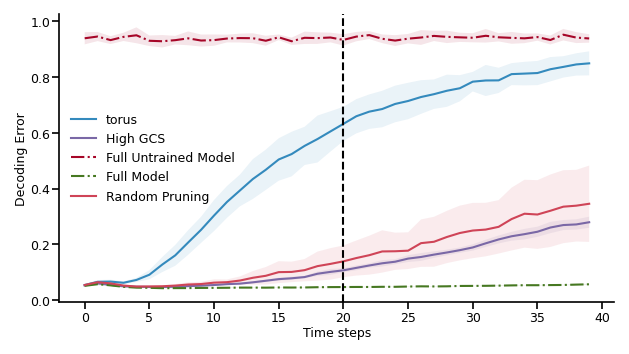

In [27]:
fig, ax = plt.subplots(figsize=figsize)
x_ticks = np.arange(0,seq_len,1)
labels = cluster_labels + ['Full Untrained Model'] + ['High GCS'] + ['Full Model'] + ['Random Pruning']
ls = ['-']*(len(clusters)+4)
ls[-4] = '-.'
ls[-2] = '-.'

mean_error = np.mean(pruning_errors,axis=0).T
std_error = np.std(pruning_errors,axis=0).T
median_error = np.median(pruning_errors,axis=0).T
mad_error = mad(pruning_errors,axis=0).T
#for i in [0,1,2,3,4,6,5,7]: # set order to change color according to color-cycler
for i in [0,6,5,7,8]: # set order to change color according to color-cycler
    #ax.plot(x_ticks, mean_error[i], label=labels[i])#np.mean(pruning_i,axis=0))
    #ax.fill_between(x_ticks, mean_error[i] + std_error[i], mean_error[i] - std_error[i], alpha=0.1)
    ax.plot(x_ticks, median_error[i], label=labels[i], ls=ls[i])#np.mean(pruning_i,axis=0))
    ax.fill_between(x_ticks, median_error[i] + mad_error[i], median_error[i] - mad_error[i], alpha=0.1)

#ax.scatter(x_ticks[None]*np.ones((30,1)), pruning_errors[:,1], s=5, alpha=0.5, c=ax.lines[-1].get_color())


ax.legend()
ax.set_xlabel('Time steps')
ax.set_ylabel('Decoding Error')
ax.axvline(20, c='k', ls='--')

fig.savefig(experiment.paths['experiment'] / f'plots/time_pruning')


In [15]:
import matplotlib as mpl

print(mpl.rcParams['axes.prop_cycle'].by_key()['color'])


['#348ABD', '#7A68A6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33']
